# Notes

**Info about this data set**: https://fred.stlouisfed.org/series/IPN31152N


**Units**:  Index 2012=100, Not Seasonally Adjusted

**Frequency**:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

**Source Code**: IP.N31152.N

**Suggested Citation**:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

%matplotlib inline

2023-12-28 01:11:54.208325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read and visualize the data

In [2]:
df = pd.read_csv('DATA/Frozen_Dessert_Production.csv')
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       573 non-null    object 
 1   IPN31152N  573 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


In [4]:
# Set the date to a datetime index columns
df = pd.read_csv('DATA/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')
df.columns = ['production']
df.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


<AxesSubplot:xlabel='DATE'>

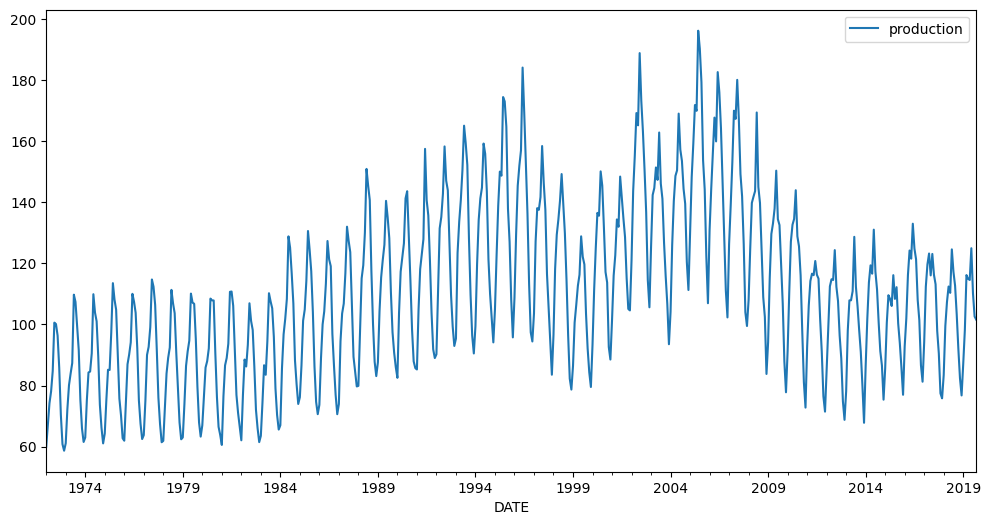

In [6]:
df.plot(figsize=(12,6))

# Data Preprocessing

In [7]:
print(f"Length of dataset: {len(df)} months")

Length of dataset: 573 months


Split the data into a train/test split where the test set is the last 24 months of data.

In [8]:
test_size = 24                   # forecast 2 years into the future
test_idx = len(df) - test_size   # index where we split between train/test sets

train_set = df.iloc[:test_idx]
test_set = df.iloc[test_idx:]

In [9]:
train_set.tail(1)

,production
DATE,
2017-09-01,97.9125


In [10]:
test_set.head(1)

,production
DATE,
2017-10-01,90.4732


In [11]:
print(len(train_set))
print(len(test_set))

549
24


Now, we'll use a MinMaxScaler to scale the train and test sets into scaled versions.

In [12]:
scaler = MinMaxScaler()

train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [13]:
print(min(train_set_scaled), max(train_set_scaled))

[0.] [1.]


In [14]:
print(min(test_set_scaled), max(test_set_scaled))

[0.12472921] [0.48213817]


Next, we will create a ``TimeSeriesGenerator`` object based off the scaled train data. The batch length should be at least 18 months to capture a full year seasonality.

In [15]:
# Let's define to get 24 months back and then predict the next month out
batch_length = 24
batch_size = 1

generator = TimeseriesGenerator(data=train_set_scaled, 
                                targets=train_set_scaled, 
                                length=batch_length,
                                batch_size=batch_size
                               )

In [16]:
# Let's now check what the first batch look like
X,y = generator[0]

print(f'Given the Array: \n\n{X.flatten()}\n\n')
print(f'Predict this y: \n\n{y}')

Given the Array: 

[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.
 0.01774221 0.09850931 0.15590133 0.18358944 0.20878908 0.37150354
 0.3542551  0.29817568 0.23973867 0.12104304 0.05289938 0.02087498]


Predict this y: 

[[0.03141355]]


# Create a Recurrent Neural Network

In [17]:
# We're only using one feature in our time series
n_features = 1

In [18]:
model = Sequential()

model.add(
    LSTM(
        units=1000, 
        activation='relu', 
        input_shape=(batch_length, n_features)
    )
)

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 4009001 (15.29 MB)
Trainable params: 4009001 (15.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In order to evaluate the performance of our model, we will create a generator for the scaled test/validation set. 

**NOTE**: We have to double check that our batch length makes sense for the size of the test set!
Using the same batch length of 24, we get the following error:

``
ValueError: `start_index+length=24 > end_index=23` is disallowed, as no part of the sequence would be left to be used as current step.
``

The scaled test dataset size MUST be greater than our chosen length for our batches.

In [20]:
validation_generator = TimeseriesGenerator(data=test_set_scaled,
                                           targets=test_set_scaled,
                                           length=batch_length-1,
                                           batch_size=batch_size
                                          )

Finally, we will create an early stopping callback to dictate the amount of epochs.

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [22]:
model.fit_generator(
    generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
525/525 [==============================] - 77s 144ms/step - loss: 0.0280 - val_loss: 0.0117
Epoch 2/50
525/525 [==============================] - 76s 144ms/step - loss: 0.0099 - val_loss: 7.6254e-04
Epoch 3/50
525/525 [==============================] - 78s 149ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 4/50
525/525 [==============================] - 73s 140ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 5/50
525/525 [==============================] - 76s 144ms/step - loss: 0.0036 - val_loss: 0.0123
Epoch 6/50
525/525 [==============================] - 79s 151ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 7/50
525/525 [==============================] - 81s 155ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7: early stopping


In [23]:
losses = pd.DataFrame(model.history.history)
losses.head()

,loss,val_loss
0,0.027950,0.011671
1,0.009941,0.000763
2,0.004435,0.006902
3,0.004121,0.001556
4,0.003576,0.012309


<AxesSubplot:>

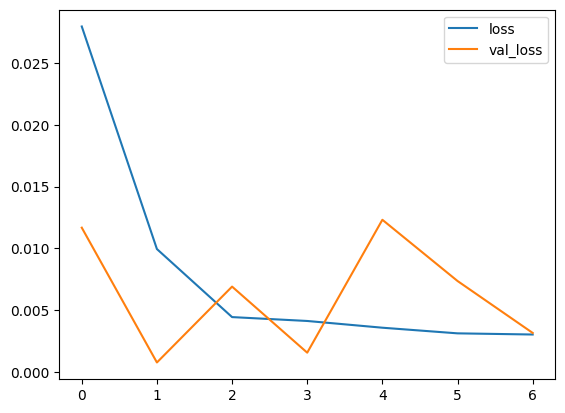

In [24]:
losses.plot()

# Evaluate Model's Performance

In [25]:
first_eval_batch = train_set_scaled[-batch_length:].reshape(batch_size, batch_length, n_features)
first_eval_batch.shape

(1, 24, 1)

In [26]:
y_pred = model.predict(first_eval_batch, verbose=0)[0]

In [27]:
print(y_pred)

[0.22995372]


In [28]:
test_set_scaled[0]

array([0.23134679])

In [29]:
print(f"RMSE = {np.sqrt(mean_squared_error(test_set_scaled[0], y_pred))}")

RMSE = 0.0013930735947272344


In [30]:
test_predictions = []

first_eval_batch = train_set_scaled[-batch_length:]
current_batch = first_eval_batch.reshape((batch_size, batch_length, n_features))

for i in range(len(test_set)):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch, verbose=0)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
test_set["predictions"] = scaler.inverse_transform(test_predictions)
test_set

,production,predictions
DATE,,
2017-10-01,90.4732,90.281633
2017-11-01,77.4378,84.485637
2017-12-01,75.8118,86.395282
2018-01-01,83.4343,96.830596
2018-02-01,99.4899,108.748280
2018-03-01,107.3152,116.944817
2018-04-01,112.4309,122.638054
2018-05-01,110.3544,128.244954
2018-06-01,124.5841,131.183502


<AxesSubplot:xlabel='DATE'>

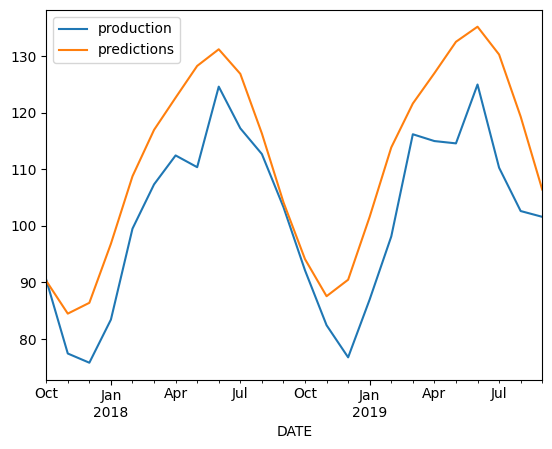

In [32]:
test_set.plot()

In [33]:
print(f"RMSE = {np.sqrt(mean_squared_error(test_set['production'], test_set['predictions']))}")

RMSE = 11.317525043832584


<AxesSubplot:xlabel='DATE'>

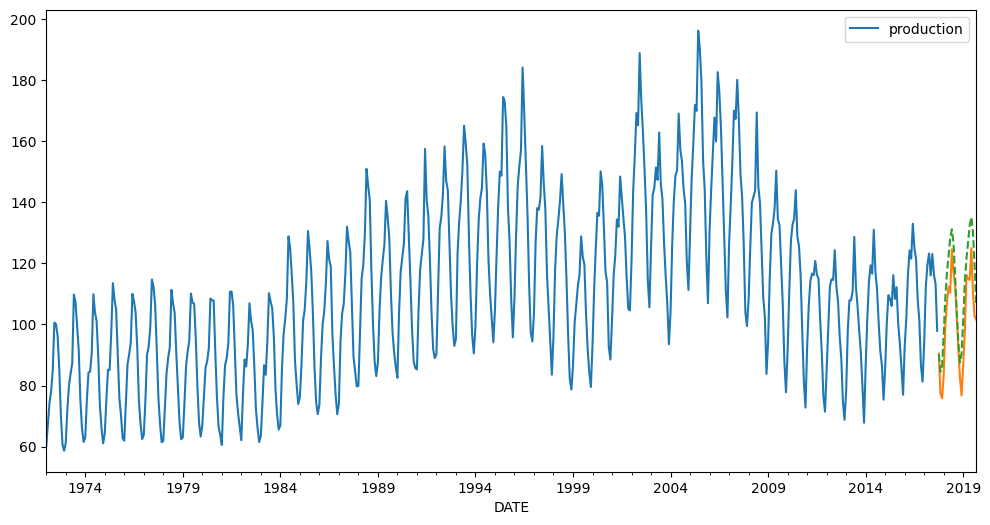

In [34]:
train_set.plot(figsize=(12,6))
test_set.production.plot()
test_set.predictions.plot(ls='--')

# Re-train on entire dataset and forecast

Load the most recent version of the dataset to compare the forecasting power of our model. This includes dates up to 2023.

In [35]:
df2 = pd.read_csv('IPN31152N.csv', parse_dates=True, index_col='DATE')
df2

,IPN31152N
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335
...,...
2023-06-01,127.5746
2023-07-01,124.7469
2023-08-01,119.1456


In [36]:
df2 = df2.iloc[len(df):]
df2.columns = ["future_production"]

In [37]:
df2.head()

,future_production
DATE,
2019-10-01,91.7124
2019-11-01,78.9224
2019-12-01,75.0474
2020-01-01,83.2602
2020-02-01,98.6914


Re-train the model using the entire original dataset.

In [38]:
full_scaler = MinMaxScaler()

full_data_scaled = full_scaler.fit_transform(df)

In [39]:
full_generator = TimeseriesGenerator(data=full_data_scaled,
                                     targets=full_data_scaled,
                                     length=batch_length,
                                     batch_size=batch_size
                                    )

In [40]:
model = Sequential()

model.add(
    LSTM(
        units=1000, 
        activation='relu', 
        input_shape=(batch_length, n_features)
    )
)

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [41]:
model.fit_generator(generator, epochs=6)

Epoch 1/6
525/525 [==============================] - 78s 146ms/step - loss: 0.0367
Epoch 2/6
525/525 [==============================] - 78s 149ms/step - loss: 0.0278
Epoch 3/6
525/525 [==============================] - 76s 145ms/step - loss: 0.0169
Epoch 4/6
525/525 [==============================] - 76s 144ms/step - loss: 0.0059
Epoch 5/6
525/525 [==============================] - 82s 156ms/step - loss: 0.0039
Epoch 6/6
525/525 [==============================] - 81s 155ms/step - loss: 0.0037


In [42]:
forecast = []

first_eval_batch = full_data_scaled[-batch_length:]
current_batch = first_eval_batch.reshape(batch_size, batch_length, n_features)

for i in range(len(df2)):
    
    current_pred = model.predict(current_batch, verbose=0)[0]
    
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [43]:
forecast = full_scaler.inverse_transform(forecast)

In [44]:
df2["forecast"] = forecast
df2.head()

,future_production,forecast
DATE,,
2019-10-01,91.7124,83.272869
2019-11-01,78.9224,78.483222
2019-12-01,75.0474,79.299390
2020-01-01,83.2602,84.232435
2020-02-01,98.6914,91.550917


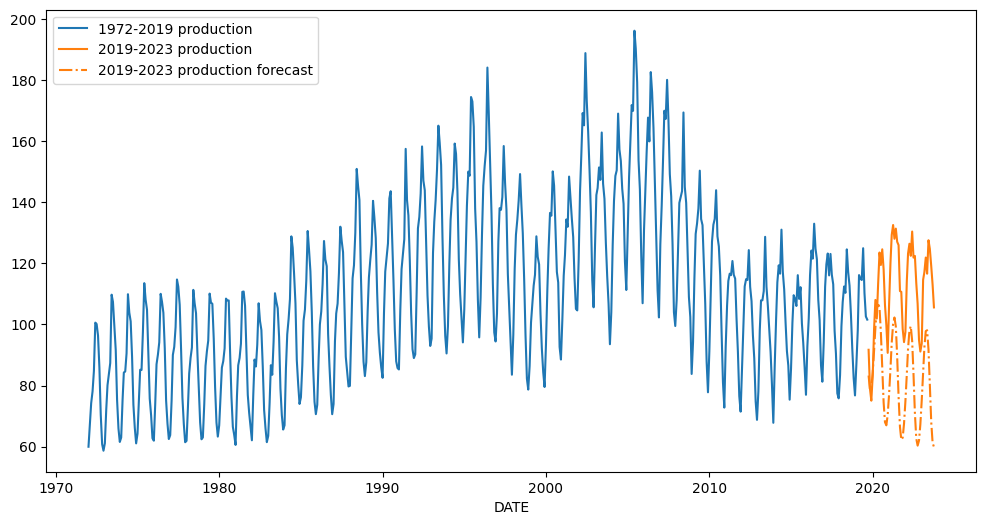

In [45]:
plt.figure(figsize=(12,6))

plt.xlabel("DATE")

plt.plot(df.index, df.production, label="1972-2019 production")
plt.plot(df2.index, df2.future_production, c='tab:orange', label='2019-2023 production')
plt.plot(df2.index, df2.forecast, label='2019-2023 production forecast', c='tab:orange', ls='-.')

plt.legend(loc='upper left')

Our model is able to accurately forecast the production within a 6-7 months time window. As the forecasting horizon increases, the model quickly deteriorates and loses much of its predictive power for long-term predictions. This is expected since the absence of ground truth beyond a certain point makes it difficult for the model to correct errors, leading to increasing forecasting inaccuracies.
These errors can accumulate over time, and small inaccuracies in the initial predictions may lead to significant deviations from the actual data.